In [1]:
import sys

#key python packages
import numpy as np
import pandas as pd

#data visualization
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# statistics
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind

#sklearn
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

# pySEAS packages
sys.path.append('/home/feldheimlab/Documents/pySEAS/')#only use if you clone repository, if pip installed no need
from seas.hdf5manager import hdf5manager as h5

# plt.style.use('publication')
dataset_path = '/media/feldheimlab/DF Transfer/misc - IS THIS YOURS/p21_20m/'
plt.rcParams['font.size'] = 8

save = True
save_dir = '/home/feldheimlab/Desktop/figures/'


In [2]:
wd = './data/'

data = pd.read_csv(wd+'training_dataset.tsv', sep='\t', index_col='exp_ic')

data = data.sort_index()
data = data.fillna(0)
print(data.head())
j=-1
current = 'Nope'
for i, ind in enumerate(data.index):
    if ind[:12]==current:
        data.loc[ind,'anml']=j
    else:
        j+=1
        data.loc[ind,'anml']=j
        current=ind[:12]
print(len(data))

#renaming the columns
neural_dict = {}

for col in data.columns:
    if "." in col:
        new_col = col.replace(".", "_")
        neural_dict[col] = new_col
#     else:
#         neural_dict[col] = col

data = data.rename(columns=neural_dict)
data.loc[data['artifact'] == 0, 'class'] = 5
data.loc[data['hemodynamic'] == 1, 'class'] = 0
data.loc[data['movement'] == 1, 'class'] = 1

dataNoThresh = data[data['threshold_area'] == 0].copy()

dataThresh = data[data['threshold_area'] != 0].copy()

print('Full dataset: ', len(data))
print('Those with threshold: ', len(dataThresh))
print('Those without threshold: ', len(dataNoThresh))
print(dataThresh.columns)

                   age  freq.avgsnr  freq.integrate  freq.maxsnr  \
exp_ic                                                             
190408_03-04-0000   22     1.193897        0.006304     1.327806   
190408_03-04-0001   22     1.422100        0.120683     1.620314   
190408_03-04-0002   22     1.296523        0.107689     1.513039   
190408_03-04-0003   22     1.172093        0.179745     1.306229   
190408_03-04-0004   22     2.093038        0.589769     3.606708   

                   freq.maxsnr.freq  freq.range.high  freq.range.low  \
exp_ic                                                                 
190408_03-04-0000          4.204482         4.585020        2.973018   
190408_03-04-0001          4.585020         0.005325        0.004883   
190408_03-04-0002          4.585020         0.005325        0.004883   
190408_03-04-0003          2.973018         0.963882        0.371627   
190408_03-04-0004          3.242099         0.007530        0.004883   

                  

## Load and train on a Random Forest Classifier, get importance scores

In [3]:
scaler = StandardScaler()
rnd_clf = RandomForestClassifier(n_estimators = 500, random_state=42)

droplist = ['anml','artifact','signal','age', 'length', 'spatial_COMdom_x', 'spatial_COMdom_y', 
            'mass_perc', 'mass_region','mass_total', 'hemodynamic', 'movement']
try:
    X = data.drop(droplist, axis=1).fillna(value=0).copy()
except Exception as e:
    X = data.fillna(value=0).copy()
    print(e)
    
data_final_vars = X.columns.values.tolist()    
scaler.fit(X.values)
X[:] = scaler.transform(X.values)
y = data['signal'].copy()

rnd_clf.fit(X.values, y.values)
feat_imp = rnd_clf.feature_importances_

## Sort by type of metric

In [4]:
spatiallist = ['spatial_COMall_x', 'spatial_COMall_y', 'spatial_avg', 'spatial_max',
             'spatial_min', 'spatial_n_domains', 'spatial_std']
morphlist = ['region_centroid_0', 'region_centroid_1', 'region_eccentricity', 
             'region_extent','region_majaxis', 'region_majmin_ratio', 'region_minaxis',
             'region_orient',  'threshold_area', 'threshold_perc']
temporallist = ['temporal_autocorr','temporal_max', 'temporal_min', 'temporal_n_freq', 
                'temporal_std']
freqlist = ['freq_avgsnr', 'freq_integrate', 'freq_maxsnr','freq_maxsnr_freq', 
            'freq_range_high', 'freq_range_low', 'freq_rangesz']


print(data.columns)
droplist = ['age', 'length', 'spatial_COMdom_x', 'spatial_COMdom_y', 'mass_perc', 'mass_region','mass_total']
dcorr = data.drop(droplist, axis=1)
dcorr = dcorr.drop(['artifact', 'signal'], axis=1).corrwith(data['signal'],method='pearson')

sort = dcorr.sort_values(ascending=False)
t = np.concatenate((sort[:,None],sort[:,None]), axis=1)
sdata = t[sort.index.isin(spatiallist)]
mdata = t[sort.index.isin(morphlist)]
tdata = t[sort.index.isin(temporallist)]
fdata = t[sort.index.isin(freqlist)]


Index(['age', 'freq_avgsnr', 'freq_integrate', 'freq_maxsnr',
       'freq_maxsnr_freq', 'freq_range_high', 'freq_range_low', 'freq_rangesz',
       'length', 'mass_perc', 'mass_region', 'mass_total', 'region_centroid_0',
       'region_centroid_1', 'region_eccentricity', 'region_extent',
       'region_majaxis', 'region_majmin_ratio', 'region_minaxis',
       'region_orient', 'signal', 'spatial_COMall_x', 'spatial_COMall_y',
       'spatial_COMdom_x', 'spatial_COMdom_y', 'spatial_avg', 'spatial_max',
       'spatial_min', 'spatial_n_domains', 'spatial_std', 'temporal_autocorr',
       'temporal_max', 'temporal_min', 'temporal_n_freq', 'temporal_std',
       'threshold_area', 'threshold_perc', 'anml', 'artifact', 'hemodynamic',
       'movement', 'class'],
      dtype='object')


/tmp/ipykernel_416735/100594416.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  t = np.concatenate((sort[:,None],sort[:,None]), axis=1)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data[~np.isnan(data)])
dataAll = data.copy()
dataAll[:] = scaler.transform(dataAll[~np.isnan(data)].values)

def populationModeDiff(vector1, vector2, bins = 25):
    hist, bin_edges = np.histogram(vector1, bins= bins)
    hist2, bin_edges2 = np.histogram(vector2, bins= bins)
    return bin_edges[np.argmax(hist)] - bin_edges2[np.argmax(hist2)]

sdata_mode = np.zeros(sdata.shape[0])
mdata_mode = np.zeros(mdata.shape[0])
tdata_mode = np.zeros(tdata.shape[0])
fdata_mode = np.zeros(fdata.shape[0])

sdata_median = np.zeros(sdata.shape[0])
mdata_median = np.zeros(mdata.shape[0])
tdata_median = np.zeros(tdata.shape[0])
fdata_median = np.zeros(fdata.shape[0])


for i, met in enumerate(spatiallist):
    sdata_mode[i] = populationModeDiff(dataAll.loc[(data['signal']==1)&(~np.isnan(data[met])), met], dataAll.loc[(data['signal']==0)&(~np.isnan(data[met])), met])
for i, met in enumerate(morphlist):
    mdata_mode[i] = populationModeDiff(dataAll.loc[(data['signal']==1)&(~np.isnan(data[met])), met], dataAll.loc[(data['signal']==0)&(~np.isnan(data[met])), met])
for i, met in enumerate(temporallist):
    tdata_mode[i] = populationModeDiff(dataAll.loc[(data['signal']==1)&(~np.isnan(data[met])), met], dataAll.loc[(data['signal']==0)&(~np.isnan(data[met])), met])
for i, met in enumerate(freqlist):
    fdata_mode[i] = populationModeDiff(dataAll.loc[(data['signal']==1)&(~np.isnan(data[met])), met], dataAll.loc[(data['signal']==0)&(~np.isnan(data[met])), met])
    
# for i, met in enumerate(spatiallist):
#     sdata_mode[i] = np.nanmean(dataAll.loc[data['signal']==1, met]) - np.nanmean(dataAll.loc[data['signal']==0, met])
# for i, met in enumerate(morphlist):
#     mdata_mode[i] = np.nanmean(dataAll.loc[data['signal']==1, met]) - np.nanmean(dataAll.loc[data['signal']==0, met])
# for i, met in enumerate(temporallist):
#     tdata_mode[i] = np.nanmean(dataAll.loc[data['signal']==1, met]) - np.nanmean(dataAll.loc[data['signal']==0, met])
# for i, met in enumerate(freqlist):
#     fdata_mode[i] = np.nanmean(dataAll.loc[data['signal']==1, met]) - np.nanmean(dataAll.loc[data['signal']==0, met])
    

/home/feldheimlab/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Scatter plot for feature selection metrics

0 1.0 class
1 0.5940841577802546 region_minaxis
2 0.3801581570241215 threshold_area
3 0.2552144210708797 spatial_max
4 0.24102898736894385 spatial_min
5 0.16515697036883561 region_extent
6 0.11098087105132354 region_majaxis
7 0.08521410624751422 freq_rangesz
8 0.08050381184757016 freq_range_low
9 0.07490481508706634 freq_range_high
10 0.07303892759308846 region_eccentricity
11 0.06249909459715825 region_majmin_ratio
12 0.056811442171762094 temporal_std
13 0.046776217312891555 temporal_max
14 0.0438582894337702 temporal_min
15 0.026802056386184065 region_centroid_0
16 0.025695132078705146 threshold_perc
17 0.020081188540050747 spatial_n_domains
18 0.01796751656124784 region_centroid_1
19 0.014769856629909584 freq_integrate
20 0.013704206971221536 spatial_COMall_y
21 0.011822317608383969 spatial_std
22 0.011650547548550631 temporal_autocorr
23 0.010042652269735854 spatial_COMall_x
24 0.009194995439823118 region_orient
25 0.008722318512364095 freq_maxsnr_freq
26 0.007223399133872378 spati

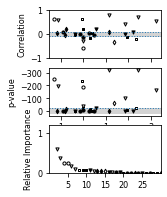

In [6]:
fig, axs = plt.subplots(3,1, figsize=(2,3))


domain_vars = ['freq_range_high', 'freq_range_low', 'freq_rangesz',
'region_eccentricity', 'region_extent', 'region_majaxis', 'region_majmin_ratio', 'region_minaxis', 'threshold_area','threshold_perc',
'spatial_max','spatial_min',
'temporal_max', 'temporal_min', 'temporal_std']

cmap = plt.cm.get_cmap('Reds')

max_feature_imp = np.nanmax(rnd_clf.feature_importances_)
markersize = 10
markersize2 = 7

fulllist = []

pvaluecutt = -25
corrcutt = 0.10
diffcutt = 2.5

end = np.zeros(4)

k = 0

sort_import = np.sort(rnd_clf.feature_importances_)[::-1]
argsort_import = np.argsort(rnd_clf.feature_importances_, )[::-1]
# print(data_final_vars[argsort_import])

for l, arg in enumerate(argsort_import):
    print(l, sort_import[l]/max_feature_imp, data_final_vars[arg])

rownames = sort.index[sort.index.isin(spatiallist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
        if row == var:
            if (np.abs(sdata[i,0]) >= corrcutt) & (np.log10(pvalue)<pvaluecutt) or (np.abs(sdata_mode[i]) > diffcutt):
                fulllist.append(row)
                axs[0].scatter(sdata_mode[i], sdata[i,0], marker="o",s=markersize, 
                             c='w', edgecolors = 'k', linewidth = 1)
                axs[1].scatter(sdata_mode[i], np.log10(pvalue), marker="o",s=markersize,
                             c='w', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp ,marker="o",s=markersize,
#                              c='w', edgecolors = 'k', linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="o",s=markersize,
                                     c='w', edgecolors = 'k', linewidth = 1)
            else:
                axs[0].scatter(sdata_mode[i], sdata[i,0], marker="o",s=markersize, 
                             c='k', edgecolors = 'k', linewidth = 1)
                axs[1].scatter(sdata_mode[i], np.log10(pvalue), marker="o",s=markersize,
                             c='k', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp ,marker="o",s=markersize,
#                              c='k', edgecolors = 'k', linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="o",s=markersize,
                                     c='k', edgecolors = 'k', linewidth = 1)
            k+=1
            end[0]=k

rownames = sort.index[sort.index.isin(morphlist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            if row == 'region_minaxis':
                pvalue = 10**(-320)
            if (np.abs(mdata[i,0]) >= corrcutt) & (np.log10(pvalue)<pvaluecutt) or (np.abs(mdata_mode[i]) > diffcutt):
                fulllist.append(row)            
                axs[0].scatter(mdata_mode[i], mdata[i,0], marker="v",s=markersize,
                             c='w', edgecolors = 'k', #cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                             linewidth = 1)
                axs[1].scatter(mdata_mode[i],np.log10(pvalue), marker="v",s=markersize,
                             c='w', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp, marker="v",s=markersize,
#                              c='w', edgecolors = 'k', linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="v",s=markersize,
                                     c='w', edgecolors = 'k', linewidth = 1)
            else:
                axs[0].scatter(mdata_mode[i], mdata[i,0], marker="v",s=markersize,
                             c='k', edgecolors = 'k', #cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                             linewidth = 1)
                axs[1].scatter(mdata_mode[i],np.log10(pvalue), marker="v",s=markersize,
                             c='k', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp, marker="v",s=markersize,
#                              c='k', edgecolors = 'k', linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="v",s=markersize,
                                     c='k', edgecolors = 'k', linewidth = 1)
            k+=1
            end[1]=k

rownames = sort.index[sort.index.isin(temporallist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            if (np.abs(tdata[i,0]) >= corrcutt) & (np.log10(pvalue)<pvaluecutt) or (np.abs(tdata_mode[i]) > diffcutt):
                fulllist.append(row)
                axs[0].scatter(tdata_mode[i], tdata[i,0], marker="d",s=markersize,
                             c='w', edgecolors = 'k', linewidth = 1)             
                axs[1].scatter(tdata_mode[i],np.log10(pvalue), marker="d",s=markersize,
                             c='w', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp, marker="d",s=markersize,
#                              c='w', edgecolors = 'k', linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="d",s=markersize,
                                     c='w', edgecolors = 'k', linewidth = 1)
            else:
                axs[0].scatter(tdata_mode[i], tdata[i,0], marker="d",s=markersize,
                                 c='k', edgecolors = 'k', linewidth = 1)             
                axs[1].scatter(tdata_mode[i],np.log10(pvalue), marker="d",s=markersize,
                             c='k', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp, marker="d",s=markersize,
#                              c='k', edgecolors = 'k', linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="d",s=markersize,
                                     c='k', edgecolors = 'k', linewidth = 1)
            k+=1
            end[2]=k
                
rownames = sort.index[sort.index.isin(freqlist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            if (np.abs(fdata[i,0]) >= corrcutt) & (np.log10(pvalue)<pvaluecutt) or (np.abs(fdata_mode[i]) > diffcutt):
                fulllist.append(row)
                axs[0].scatter(fdata_mode[i], fdata[i,0], marker="s",s=markersize2,
                            c='w', edgecolors = 'k',#cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                            linewidth = 1)
                axs[1].scatter(fdata_mode[i],np.log10(pvalue), marker="s",s=markersize2,
                             c='w', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp, marker="s",s=markersize2,
#                              c='w', edgecolors = 'k', linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="s",s=markersize2,
                                     c='w', edgecolors = 'k', linewidth = 1)
            else:
                axs[0].scatter(fdata_mode[i], fdata[i,0], marker="s",s=markersize2,
                            c='k',#cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                            edgecolors = 'k', linewidth = 1)
                axs[1].scatter(fdata_mode[i],np.log10(pvalue), marker="s",s=markersize2,
                             c='k', edgecolors = 'k', linewidth = 1)
#                 axs[2].scatter(k, rnd_clf.feature_importances_[j]/max_feature_imp, marker="s",s=markersize2,
#                              c='k', edgecolors = 'k',linewidth = 1)
                for l, arg in enumerate(argsort_import):
                    if data_final_vars[arg] == row:
                        axs[2].scatter(l, sort_import[l]/max_feature_imp ,marker="s",s=markersize2,
                                     c='k', edgecolors = 'k', linewidth = 1)
            k+=1
            end[3]=k
                  
axs[0].set_ylabel('Correlation')
axs[0].set_ylim([-1,1])
axs[0].set_xticklabels([])
lims = axs[0].get_xlim()
axs[0].fill_between(lims, [corrcutt,corrcutt], [-corrcutt,-corrcutt], color = 'lightgrey', zorder=0)
axs[0].hlines(corrcutt, xmin=lims[0], xmax=lims[1], linewidth=1, linestyle=':')
axs[0].hlines(-corrcutt, xmin=lims[0], xmax=lims[1], linewidth=1, linestyle=':')
axs[0].set_xticks([-1,0,1,2,3])

axs[0].set_xlim(lims)

axs[1].hlines(pvaluecutt, xmin=lims[0], xmax=lims[1], linewidth=1, linestyle=':')
axs[1].set_ylabel('p-value')
axs[1].set_xlabel('Mode difference')
axs[1].fill_between(lims, [pvaluecutt,pvaluecutt], [axs[1].get_ylim()[1],axs[1].get_ylim()[1]], color = 'lightgrey', zorder=0)
axs[1].set_ylim(axs[1].get_ylim()[::-1])
axs[1].set_xticks([-1,0,1,2,3])
axs[1].set_xticklabels(['-1','','1','','3'])
axs[1].set_yticks([0,-100,-200,-300])
axs[1].set_xlim(lims)

# print(end)
# print((end[:-1] - end[1:])/2)
# tic = end + (end[:-1] - end[1:])/2
axs[2].set_xticks(np.arange(4,l,5))
axs[2].set_xticklabels(np.arange(5,l+1,5))

# axs[2].set_xticklabels(['spat.', 'morph.', 'temp.', 'freq.'])
print(l)
axs[2].set_xlim(-1,l)
axs[2].set_ylim(0,1.2)
axs[2].set_ylabel('Relative Importance')

# axs2.set_ylim([1, 800])
# fig.tight_layout()
if save:
    fig.savefig(save_dir+'feature_scatter_mode_corr_notext.svg', dpi = 600)

plt.show()

spatial_min 38.642007825890516
spatial_max -32.080343707860905
region_minaxis 57.26963738856556
threshold_area 45.89526296420727
region_extent 33.64927568455187
threshold_perc 30.0308311314933
region_majaxis 23.224554510061644
region_majmin_ratio -14.292224994520664
temporal_min -18.051165903056084
freq_rangesz 37.057603763457514
3 0.2552144210708797 spatial_max
4 0.24102898736894385 spatial_min
17 0.020081188540050747 spatial_n_domains
20 0.013704206971221536 spatial_COMall_y
21 0.011822317608383969 spatial_std
23 0.010042652269735854 spatial_COMall_x
26 0.007223399133872378 spatial_avg
1 0.5940841577802546 region_minaxis
2 0.3801581570241215 threshold_area
5 0.16515697036883561 region_extent
6 0.11098087105132354 region_majaxis
10 0.07303892759308846 region_eccentricity
11 0.06249909459715825 region_majmin_ratio
15 0.026802056386184065 region_centroid_0
16 0.025695132078705146 threshold_perc
18 0.01796751656124784 region_centroid_1
24 0.009194995439823118 region_orient
12 0.056811442

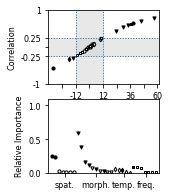

In [7]:
fig, axs = plt.subplots(2,1, figsize=(2,3))

domain_vars = ['freq_range_high', 'freq_range_low', 'freq_rangesz',
'region_eccentricity', 'region_extent', 'region_majaxis', 'region_majmin_ratio', 'region_minaxis', 'threshold_area','threshold_perc',
'spatial_max','spatial_min',
'temporal_max', 'temporal_min', 'temporal_std'
]

cmap = plt.cm.get_cmap('Reds')

max_feature_imp = np.nanmax(rnd_clf.feature_importances_)
markersize = 10
markersize2 = 7

fulllist = []

tstatcutt = 12
corrcutt = 0.25
diffcutt = 2.5

end = np.zeros(4)

k = 0

sort_import = np.sort(rnd_clf.feature_importances_)[::-1]
argsort_import = np.argsort(rnd_clf.feature_importances_, )[::-1]
rownames = sort.index[sort.index.isin(spatiallist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
        if row == var:
            if (np.abs(sdata[i,0]) >= corrcutt) & (np.abs(tstat)>tstatcutt) or (np.abs(sdata_mode[i]) > diffcutt):
                print(row, tstat)
                fulllist.append(row)
                axs[0].scatter(tstat, sdata[i,0], marker="o",s=markersize, 
                             c='k', edgecolors = 'k', linewidth = 1)
            else:
                axs[0].scatter(tstat, sdata[i,0], marker="o",s=markersize, 
                             c='w', edgecolors = 'k', linewidth = 1)
                
rownames = sort.index[sort.index.isin(morphlist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            if row == 'region_minaxis':
                pvalue = 10**(-320)
            if (np.abs(mdata[i,0]) >= corrcutt) & (np.abs(tstat)>tstatcutt) or (np.abs(mdata_mode[i]) > diffcutt):
                print(row, tstat)                
                fulllist.append(row)            
                axs[0].scatter(tstat, mdata[i,0], marker="v",s=markersize,
                             c='k', edgecolors = 'k', #cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                             linewidth = 1)
            else:
                axs[0].scatter(tstat, mdata[i,0], marker="v",s=markersize,
                             c='w', edgecolors = 'k', #cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                             linewidth = 1)
        
rownames = sort.index[sort.index.isin(temporallist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            if (np.abs(tdata[i,0]) >= corrcutt) & (np.abs(tstat)>tstatcutt) or (np.abs(tdata_mode[i]) > diffcutt):
                print(row, tstat)
                fulllist.append(row)
                axs[0].scatter(tstat, tdata[i,0], marker="d",s=markersize,
                             c='k', edgecolors = 'k', linewidth = 1)             
            else:
                axs[0].scatter(tstat, tdata[i,0], marker="d",s=markersize,
                                 c='w', edgecolors = 'k', linewidth = 1)             
        
rownames = sort.index[sort.index.isin(freqlist)]
for i, row in enumerate(rownames):
    for j, var in enumerate(data_final_vars):
        if row == var:
            tstat, pvalue = ttest_ind(dataAll[row][data['artifact']==0], dataAll[row][data['artifact']==1])
            if (np.abs(fdata[i,0]) >= corrcutt) & (np.abs(tstat)>tstatcutt) or (np.abs(fdata_mode[i]) > diffcutt):
                print(row, tstat)
                fulllist.append(row)
                axs[0].scatter(tstat, fdata[i,0], marker="s",s=markersize2,
                            c='k', edgecolors = 'k',#cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                            linewidth = 1)
            else:
                axs[0].scatter(tstat, fdata[i,0], marker="s",s=markersize2,
                            c='w',#cmap(rnd_clf.feature_importances_[j]/max_feature_imp), 
                            edgecolors = 'k', linewidth = 1)

for l, arg in enumerate(argsort_import):
    if data_final_vars[arg] in spatiallist:
        if data_final_vars[arg] in fulllist:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="o",s=markersize,
                                 c='k', edgecolors = 'k', linewidth = 1)
        else:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="o",s=markersize,
                                 c='w', edgecolors = 'k', linewidth = 1)
        k+=1
        end[0]=k
        print(l, sort_import[l]/max_feature_imp, data_final_vars[arg])
        
for l, arg in enumerate(argsort_import):
    if data_final_vars[arg] in morphlist:
        if data_final_vars[arg] in fulllist:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="v",s=markersize,
                                 c='k', edgecolors = 'k', linewidth = 1)
        else:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="v",s=markersize,
                                 c='w', edgecolors = 'k', linewidth = 1)
        k+=1
        end[1]=k
        print(l, sort_import[l]/max_feature_imp, data_final_vars[arg])
        
for l, arg in enumerate(argsort_import):
    if data_final_vars[arg] in temporallist:
        if data_final_vars[arg] in fulllist:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="d",s=markersize,
                                 c='k', edgecolors = 'k', linewidth = 1)
        else:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="d",s=markersize,
                                 c='w', edgecolors = 'k', linewidth = 1)
        k+=1
        end[2]=k
        print(l, sort_import[l]/max_feature_imp, data_final_vars[arg])
        
for l, arg in enumerate(argsort_import):
    if data_final_vars[arg] in freqlist:
        if data_final_vars[arg] in fulllist:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="s",s=markersize2,
                                 c='k', edgecolors = 'k', linewidth = 1)
        else:
            axs[1].scatter(k, sort_import[l]/max_feature_imp ,marker="s",s=markersize2,
                                 c='w', edgecolors = 'k', linewidth = 1)
        k+=1
        end[3]=k
        print(l, sort_import[l]/max_feature_imp, data_final_vars[arg])
        
axs[0].set_ylabel('Correlation')
axs[0].set_ylim([-1,1])
axs[0].set_yticks([-1,-corrcutt, 0, corrcutt, 1])
axs[0].set_yticklabels(['-1','-{}'.format(corrcutt),'', '{}'.format(corrcutt), '1'])

lims = axs[0].get_xlim()
axs[0].fill_between(lims, [corrcutt,corrcutt], [-corrcutt,-corrcutt], color = 'lightgrey', alpha=0.5, zorder=0)
axs[0].hlines(corrcutt, xmin=lims[0], xmax=lims[1], linewidth=1, linestyle=':')
axs[0].hlines(-corrcutt, xmin=lims[0], xmax=lims[1], linewidth=1, linestyle=':')
axs[0].axvspan(-tstatcutt,tstatcutt, color = 'lightgrey', alpha=0.5, zorder=0)
axs[0].vlines(tstatcutt, ymin=-1, ymax=1, linewidth=1, linestyle=':')
axs[0].vlines(-tstatcutt, ymin=-1, ymax=1, linewidth=1, linestyle=':')


axs[0].set_xlim(lims)
axs[0].set_xticks([-2*tstatcutt,-tstatcutt,0,tstatcutt,2*tstatcutt, 3*tstatcutt,4*tstatcutt,5*tstatcutt])
axs[0].set_xticklabels(['','-{}'.format(tstatcutt),'','{}'.format(tstatcutt),'','{}'.format(3*tstatcutt), '','{}'.format(5*tstatcutt)])

axs[0].set_xlabel('t-statistic')

axs[1].set_xticks([end[0]/2, end[0]+(end[1]-end[0])/2,end[1]+(end[2]-end[1])/2,end[2]+(end[3]-end[2])/2])

axs[1].set_xticklabels(['spat.', 'morph.', 'temp.', 'freq.'])
axs[1].set_xlim(-1,l)
axs[1].set_ylim(0,1.1)
axs[1].set_ylabel('Relative Importance')

if save:
    fig.savefig(save_dir+'feature_scatter_corr_tstat_notext_OB.svg', dpi = 600)

plt.show()

# PCA projected data with metric mapping

In [8]:
#creating appropriate datasets
# ---------------------------------------------------------

domain_vars = ['freq_range_high', 'freq_range_low', 'freq_rangesz',
'region_eccentricity', 'region_extent', 'region_majaxis', 'region_majmin_ratio', 'region_minaxis', 'threshold_area','threshold_perc',
'spatial_max','spatial_min',
'temporal_max', 'temporal_min', 'temporal_std'
]

data = data.fillna(value=0).copy()
dataAll = data[fulllist].copy()

#standardize
for col in fulllist:
    dataAll[col] = (data[col] - np.mean(data[col])) / (np.std(data[col], ddof=1)) 


In [9]:
#Plotting TruncatedSVD Plot
# ---------------------------------------------------------
svd = TruncatedSVD(n_components=2, n_iter=100, random_state=42)
X_reduced_SVD = svd.fit_transform(dataAll.values)


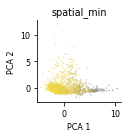

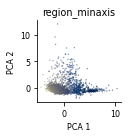

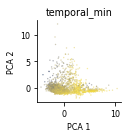

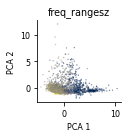

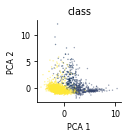

In [10]:

metrics = ['spatial_min', 'region_minaxis',  'temporal_min','freq_rangesz', 'class']

for metric in metrics:
    fig, axs = plt.subplots(1, 1, figsize = (1.5,1.5), sharex=True, sharey = True)
    plt.subplots_adjust(wspace = 0.3)
    axs.scatter(X_reduced_SVD[:, 0], 
                      X_reduced_SVD[:, 1],
                      c=data.loc[dataAll.index, metric], 
                    cmap=plt.cm.get_cmap('cividis'), edgecolors='none', s = 2, alpha = 0.5)
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.yaxis.set_ticks_position('left')
    axs.xaxis.set_ticks_position('bottom')
    axs.set_xlabel('PCA 1')
    axs.set_ylabel('PCA 2')
    axs.title.set_text(metric)
    if save:
        fig.savefig(save_dir+'SVD_plots_all_{}.png'.format(metric), dpi = 600)
    plt.show()


/home/feldheimlab/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in true_divide
  hist /= s
/home/feldheimlab/.local/lib/python3.8/site-packages/matplotlib/contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/feldheimlab/.local/lib/python3.8/site-packages/matplotlib/contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/tmp/ipykernel_416735/4161571633.py:26: UserWarning: linewidths is ignored by contourf
  CS0 = ax0.contourf(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
/tmp/ipykernel_416735/4161571633.py:32: UserWarning: linewidths is ignored by contourf
  CS1 = ax0.contourf(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
/tmp/ipykernel_416735/4161571633.py:38: UserWarning: linewidths is ignored by contourf
  CS1 = ax0.contourf(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.m

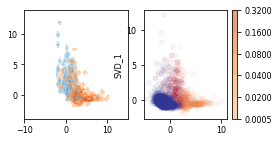

In [16]:
fig = plt.figure(figsize = (4,2), constrained_layout=False)

gs = fig.add_gridspec(1, 2)
gs.update(wspace = 0.15, hspace = 1)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

levels = [0.0005, .02,.04,.08,.16,.32]
redcolor = matplotlib.cm.get_cmap('Reds')
bluecolor = matplotlib.cm.get_cmap('Blues')
yellowcolor = matplotlib.cm.get_cmap('Oranges')

blu = [bluecolor(100), bluecolor(125), bluecolor(150),bluecolor(175),bluecolor(200),bluecolor(255)]
red = [redcolor(100), redcolor(125), redcolor(150),redcolor(175),redcolor(200),redcolor(255)]
yel = [yellowcolor(100),yellowcolor(125), yellowcolor(150),yellowcolor(175),yellowcolor(200),yellowcolor(255)]

ph1 = ax1.scatter(X_reduced_SVD[:, 0], 
                  X_reduced_SVD[:, 1],
                  c=data.loc[dataAll.index, 'class'], 
                 cmap=plt.cm.get_cmap('RdYlBu',5), s = 20, alpha = 0.05)
ax1.set_ylabel('SVD_1')

counts,ybins,xbins = np.histogram2d(X_reduced_SVD[:, 1][data['class']==2],
                                    X_reduced_SVD[:, 0][data['class']==2], bins=25, normed=True)
CS0 = ax0.contourf(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
            linewidths=3, levels=levels, colors=red, alpha=0.5)

counts,ybins,xbins = np.histogram2d(X_reduced_SVD[:, 1][data['class']==0],
                                    X_reduced_SVD[:, 0][data['class']==0],bins=25, normed=True)

CS1 = ax0.contourf(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
            linewidths=3, levels=levels, colors=blu, alpha=0.5)

counts,ybins,xbins = np.histogram2d(X_reduced_SVD[:, 1][data['class']==1],
                                    X_reduced_SVD[:, 0][data['class']==1],bins=25, normed=True)

CS1 = ax0.contourf(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
            linewidths=3, levels=levels, colors=yel, alpha=0.5)

ax0.set_ylim(-4,14)
ax0.set_xlim(-10,15)

cbar2 = fig.colorbar(CS1)

if save:
    fig.savefig(save_dir+'SVD_plots_all.svg', dpi = 600)
plt.show()

# Covariance matrices for all metrics


Index(['age', 'freq_avgsnr', 'freq_integrate', 'freq_maxsnr',
       'freq_maxsnr_freq', 'freq_range_high', 'freq_range_low', 'freq_rangesz',
       'length', 'mass_perc', 'mass_region', 'mass_total', 'region_centroid_0',
       'region_centroid_1', 'region_eccentricity', 'region_extent',
       'region_majaxis', 'region_majmin_ratio', 'region_minaxis',
       'region_orient', 'signal', 'spatial_COMall_x', 'spatial_COMall_y',
       'spatial_COMdom_x', 'spatial_COMdom_y', 'spatial_avg', 'spatial_max',
       'spatial_min', 'spatial_n_domains', 'spatial_std', 'temporal_autocorr',
       'temporal_max', 'temporal_min', 'temporal_n_freq', 'temporal_std',
       'threshold_area', 'threshold_perc', 'anml', 'artifact', 'hemodynamic',
       'movement', 'class'],
      dtype='object')


/tmp/ipykernel_416735/2069760477.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(dcorr, dtype=np.bool))


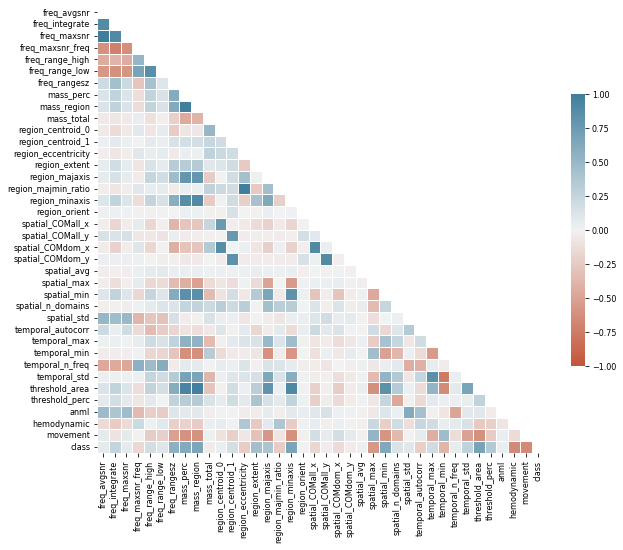

/tmp/ipykernel_416735/2069760477.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(dcorr, dtype=np.bool))


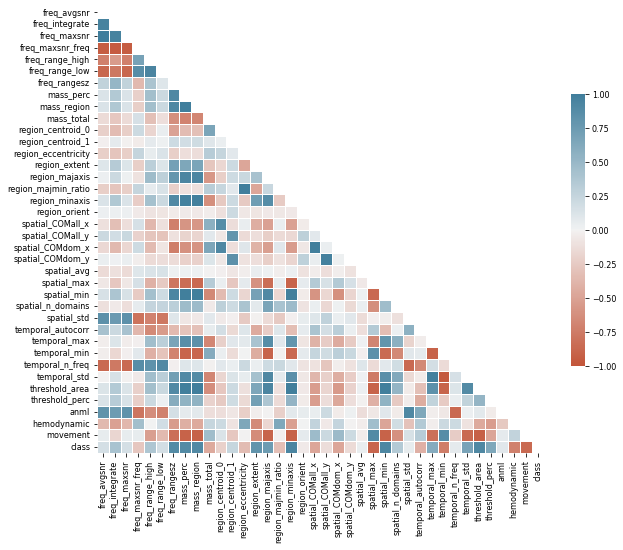

In [12]:
fig = plt.figure( figsize = (10,10), constrained_layout=False)

droplist = ['age', 'artifact', 'length', 'signal']
print(data.columns)
dcorr = data.drop(droplist, axis=1)

dcorr = dcorr.corr('spearman')
mask = np.triu(np.ones_like(dcorr, dtype=np.bool))

pal = sns.diverging_palette(20,230, as_cmap = True, center='light')
sns.heatmap(dcorr, mask = mask, cmap=pal, center = 0, vmin = -1, vmax = 1, square = True, linewidth = .5, cbar_kws={'shrink':0.5})
plt.show()

dcorr = dcorr.corr('pearson')
mask = np.triu(np.ones_like(dcorr, dtype=np.bool))

fig = plt.figure( figsize = (10,10), constrained_layout=False)

pal = sns.diverging_palette(20,230, as_cmap = True, center='light')
sns.heatmap(dcorr, mask = mask, cmap=pal, center = 0, vmin = -1, vmax = 1, square = True, linewidth = .5, cbar_kws={'shrink':0.5})
plt.show()